In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [153]:
historical_data = pd.read_csv('Data/full_cleaned_data.csv')

In [154]:
import pandas as pd
import numpy as np

def price_weather_derivative(forecast_series: pd.Series,
                              historical_data: pd.DataFrame,
                              strike: float,
                              notional: float,
                              reference_temp: float = None) -> dict:
    """
    Prices HDD and CDD weather derivatives based on temperature forecasts.

    Parameters:
    - forecast_series: pd.Series with datetime index and forecasted temperatures.
    - historical_data: pd.DataFrame with columns ['date', 'mean'] for historical temperatures.
    - strike: float, strike value of the derivative.
    - notional: float, notional value used in the payout calculation.
    - reference_temp: Optional float to override historical-based reference temperature.

    Returns:
    - dict: Dictionary with 'HDD_price' and 'CDD_price'.
    """

    # Ensure datetime formats
    historical_data = historical_data.copy()
    historical_data['date'] = pd.to_datetime(historical_data['date'])
    forecast_series.index = pd.to_datetime(forecast_series.index)

    # Compute reference temperature if not provided
    if reference_temp is None:
        forecast_start_date = forecast_series.index[0]
        start_10_years_ago = forecast_start_date - pd.DateOffset(years=10)

        # Filter to last 10 years
        last_10_years = historical_data[historical_data['date'] >= start_10_years_ago]

        # Match month-day combinations
        forecast_month_day = set((d.month, d.day) for d in forecast_series.index)
        historical_matches = last_10_years[
            last_10_years['date'].apply(lambda d: (d.month, d.day) in forecast_month_day)
        ]

        # Calculate reference temperature
        reference_temp = historical_matches['mean'].mean()

    # Compute HDD and CDD for each day
    temps = forecast_series.values
    hdd = np.maximum(0, reference_temp - temps)
    cdd = np.maximum(0, temps - reference_temp)

    # Compute indices
    hdd_index = np.sum(hdd)
    cdd_index = np.sum(cdd)

    # Derivative prices
    hdd_price = notional * max(0, hdd_index - strike)
    cdd_price = notional * max(0, cdd_index - strike)

    return {
        "HDD_price": hdd_price,
        "CDD_price": cdd_price
    }

In [155]:
# open up csv file forecast
SARIMAforecast = pd.read_csv('Forecasts/SARIMA_Forecast.csv', index_col=0)

# Take only the first 31 rows
SARIMAforecast = SARIMAforecast.iloc[1:]

In [156]:
# Open up CSV file forecast
LSTMforecast = pd.read_csv('/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Forecasts/predictions_with_ci.csv', index_col=0)

# Drop the column 'Actual Data' from LSTMforecast
LSTMforecast = LSTMforecast.drop('Actual', axis=1)
LSTMforecast.index = SARIMAforecast[:-1].index

In [157]:
import json

# Define the file path
file_path = '/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Forecasts/forecast_mc_results.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# convert data to df
UOmodelforecast = pd.DataFrame(data)

UOmodelforecast.index = SARIMAforecast.index

In [158]:
# Assuming price_weather_derivative is defined and available
forecasts = [SARIMAforecast, UOmodelforecast, LSTMforecast]
forecast_names = ['SARIMA', 'UOmodel', 'LSTM']  # Manually specifying the model names

column_names = UOmodelforecast.columns

prices = []

for forecast, model_name in zip(forecasts, forecast_names):  # Iterate over forecasts and corresponding model names
    forecast.columns = column_names
    
    for column in column_names:
                
        # Assuming the price_weather_derivative function calculates the prices based on historical data and forecast
        result = price_weather_derivative(forecast[column], historical_data, strike=0, notional=1)
        
        # Get the HDD and CDD prices from the result
        HDDprice = result["HDD_price"]
        CDDprice = result["CDD_price"]
        # Append the resulting prices to the list
        prices.append({
            'Model': model_name,  # Use model name directly
            'Column': column,
            'HDDprice': HDDprice,
            'CDDprice': CDDprice
        })

# Optionally, convert the 'prices' list to a DataFrame if needed for easy inspection:
import pandas as pd
prices_df = pd.DataFrame(prices)

# Print or return the final DataFrame
print(prices_df)


     Model         Column     HDDprice     CDDprice
0   SARIMA  mean_forecast    56.016676   182.229868
1   SARIMA    lower_ci_95  2437.236654     0.000000
2   SARIMA    upper_ci_95     0.000000  2689.663036
3  UOmodel  mean_forecast   100.072941    26.724629
4  UOmodel    lower_ci_95   558.826847     0.946160
5  UOmodel    upper_ci_95     0.000000   409.346051
6     LSTM  mean_forecast     0.000000   534.575682
7     LSTM    lower_ci_95     3.599450   208.345737
8     LSTM    upper_ci_95     0.000000   864.404995


In [159]:
# Assuming price_weather_derivative is defined and available
forecasts = [SARIMAforecast, UOmodelforecast, LSTMforecast]
forecast_names = ['SARIMA', 'UOmodel', 'LSTM']  # Manually specifying the model names

column_names = UOmodelforecast.columns

prices = []

for forecast, model_name in zip(forecasts, forecast_names):  # Iterate over forecasts and corresponding model names
    forecast.columns = column_names
    
    for column in column_names:
                
        # Assuming the price_weather_derivative function calculates the prices based on historical data and forecast
        result = price_weather_derivative(forecast[column], historical_data, strike=0, notional=1, reference_temp=18)
        
        # Get the HDD and CDD prices from the result
        HDDprice = result["HDD_price"]
        CDDprice = result["CDD_price"]
        
        # Append the resulting prices to the list
        prices.append({
            'Model': model_name,  # Use model name directly
            'Column': column,
            'HDDprice': HDDprice,
            'CDDprice': CDDprice
        })

# Convert the list to a DataFrame for easy inspection
prices_df = pd.DataFrame(prices)

# Reshape the DataFrame to have the required format: one row per model
reshaped_df = prices_df.pivot(index='Model', columns='Column', values=['HDDprice', 'CDDprice'])

# Flatten the MultiIndex columns for easier access
reshaped_df.columns = [f'{col[0]}_{col[1]}' for col in reshaped_df.columns]

# Reset the index so the model names are included as a column
reshaped_df.reset_index(inplace=True)

# Print the reshaped DataFrame
reshaped_df


,Model,HDDprice_lower_ci_95,HDDprice_mean_forecast,HDDprice_upper_ci_95,CDDprice_lower_ci_95,CDDprice_mean_forecast,CDDprice_upper_ci_95
0,LSTM,0.000000,0.0,0.0,865.077658,1194.907054,1524.736367
1,SARIMA,1783.688298,0.0,0.0,10.363739,790.125286,3353.575131
2,UOmodel,45.204398,0.0,0.0,151.235806,590.563782,1073.258145


In [160]:
historical_data = historical_data[(historical_data['date'] >= '2024-01-01') & (historical_data['date'] < '2024-07-01')]

# Get the last value of the historical data
last_historical_date = historical_data['date'].iloc[-1]
last_historical_value = historical_data['mean'].iloc[-1]

# Filter the forecast data to align with the range of the historical data (from January 2024 onward)
SARIMAforecast_filtered = SARIMAforecast[SARIMAforecast.index >= '2024-01-01']
UOmodelforecast_filtered = UOmodelforecast[UOmodelforecast.index >= '2024-01-01']
LSTMforecast_filtered = LSTMforecast[LSTMforecast.index >= '2024-01-01']

# Add the last historical observation to the forecast data for both SARIMA and UOmodel
# For SARIMA forecast
SARIMAforecast_filtered_with_last = pd.DataFrame({
    'mean_forecast': [last_historical_value] + list(SARIMAforecast_filtered['mean_forecast']),
    'lower_ci_95': [last_historical_value] + list(SARIMAforecast_filtered['lower_ci_95']),
    'upper_ci_95': [last_historical_value] + list(SARIMAforecast_filtered['upper_ci_95'])
}, index=[last_historical_date] + list(SARIMAforecast_filtered.index))

# For UOmodel forecast
UOmodelforecast_filtered_with_last = pd.DataFrame({
    'mean_forecast': [last_historical_value] + list(UOmodelforecast_filtered['mean_forecast']),
    'lower_ci_95': [last_historical_value] + list(UOmodelforecast_filtered['lower_ci_95']),
    'upper_ci_95': [last_historical_value] + list(UOmodelforecast_filtered['upper_ci_95'])
}, index=[last_historical_date] + list(UOmodelforecast_filtered.index))

# For UOmodel forecast
LSTMforecast_filtered_with_last = pd.DataFrame({
    'mean_forecast': [last_historical_value] + list(LSTMforecast_filtered['mean_forecast']),
    'lower_ci_95': [last_historical_value] + list(LSTMforecast_filtered['lower_ci_95']),
    'upper_ci_95': [last_historical_value] + list(LSTMforecast_filtered['upper_ci_95'])
}, index=[last_historical_date] + list(LSTMforecast_filtered.index))

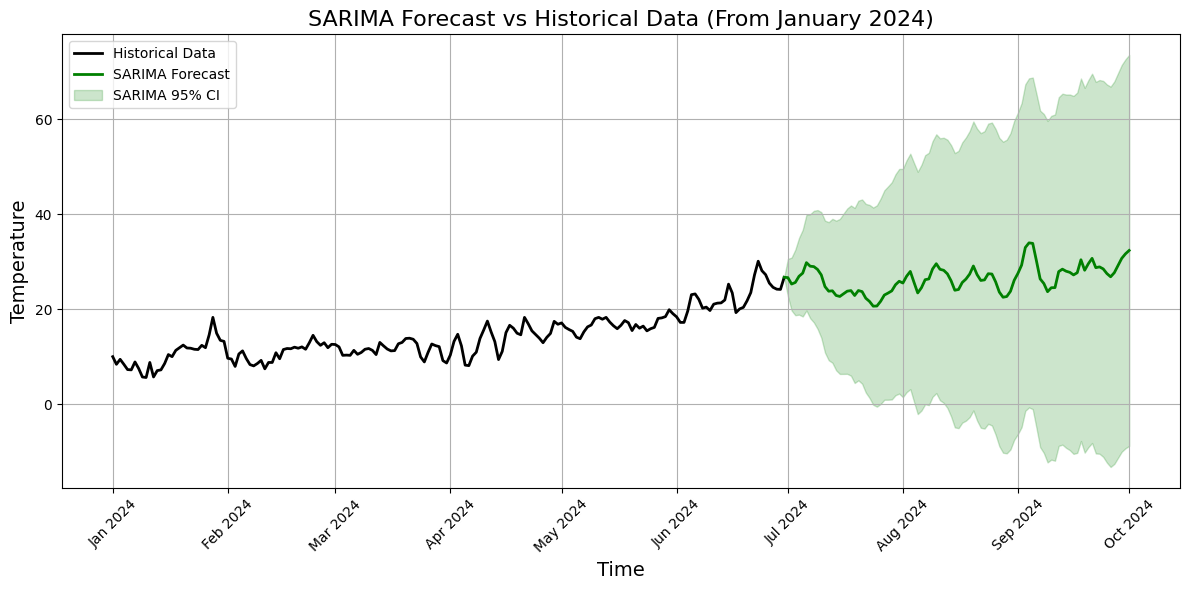

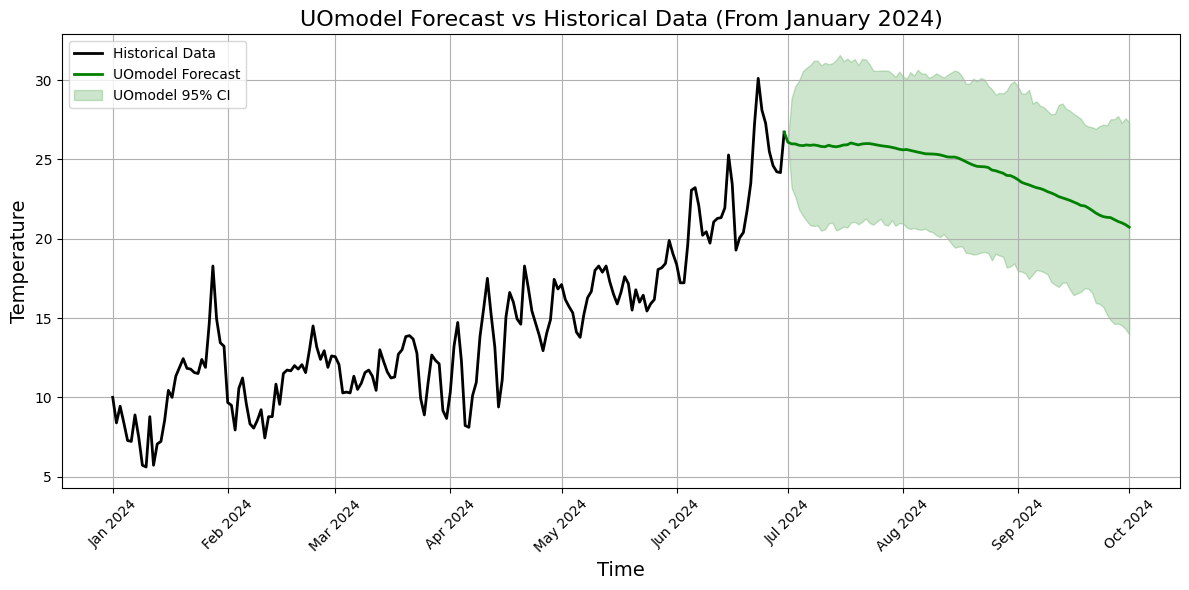

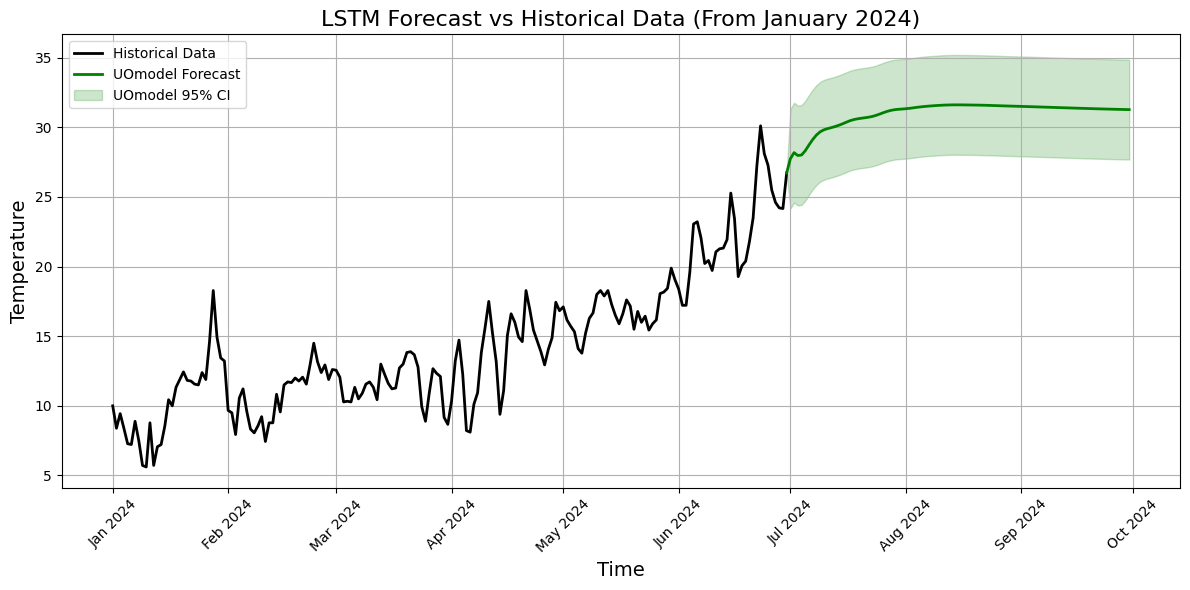

In [161]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter

# Ensure datetime index
SARIMAforecast_filtered_with_last.index = pd.to_datetime(SARIMAforecast_filtered_with_last.index)
UOmodelforecast_filtered_with_last.index = pd.to_datetime(UOmodelforecast_filtered_with_last.index)
LSTMforecast_filtered_with_last.index = pd.to_datetime(LSTMforecast_filtered_with_last.index)
historical_data['date'] = pd.to_datetime(historical_data['date'])

# SARIMA Plot
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['mean'], label='Historical Data', color='black', linewidth=2)
plt.plot(SARIMAforecast_filtered_with_last.index, SARIMAforecast_filtered_with_last['mean_forecast'], label='SARIMA Forecast', color='green', linestyle='-', linewidth=2)
plt.fill_between(SARIMAforecast_filtered_with_last.index, 
                 SARIMAforecast_filtered_with_last['lower_ci_95'], 
                 SARIMAforecast_filtered_with_last['upper_ci_95'], 
                 color='green', alpha=0.2, label='SARIMA 95% CI')

plt.title('SARIMA Forecast vs Historical Data (From January 2024)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Format x-axis to show one tick per month
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))  # e.g., Jan 2024
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# UOmodel Plot
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['mean'], label='Historical Data', color='black', linewidth=2)
plt.plot(UOmodelforecast_filtered_with_last.index, UOmodelforecast_filtered_with_last['mean_forecast'], label='UOmodel Forecast', color='green', linestyle='-', linewidth=2)
plt.fill_between(UOmodelforecast_filtered_with_last.index, 
                 UOmodelforecast_filtered_with_last['lower_ci_95'], 
                 UOmodelforecast_filtered_with_last['upper_ci_95'], 
                 color='green', alpha=0.2, label='UOmodel 95% CI')

plt.title('UOmodel Forecast vs Historical Data (From January 2024)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Format x-axis to show one tick per month
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# UOmodel Plot
plt.figure(figsize=(12, 6))
plt.plot(historical_data['date'], historical_data['mean'], label='Historical Data', color='black', linewidth=2)
plt.plot(LSTMforecast_filtered_with_last.index, LSTMforecast_filtered_with_last['mean_forecast'], label='UOmodel Forecast', color='green', linestyle='-', linewidth=2)
plt.fill_between(LSTMforecast_filtered_with_last.index, 
                 LSTMforecast_filtered_with_last['lower_ci_95'], 
                 LSTMforecast_filtered_with_last['upper_ci_95'], 
                 color='green', alpha=0.2, label='UOmodel 95% CI')

plt.title('LSTM Forecast vs Historical Data (From January 2024)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Format x-axis to show one tick per month
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [162]:
test

0     26.44
1     25.33
2     28.11
3     27.72
4     29.11
      ...  
88    21.83
89    22.22
90    21.50
91    22.78
92    26.17
Name: mean, Length: 93, dtype: float64

In [163]:
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mape = np.mean(np.abs((test - forecast) / np.where(test == 0, 1e-8, test))) * 100
    ss_res = np.sum((test - forecast) ** 2)
    ss_tot = np.sum((test - np.mean(test)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else float('-inf')  # Prevent divide-by-zero
    return rmse, mae, mape, r2

test = pd.read_csv('/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Data/test_data_HDD.csv')

test = test['mean']
metrics = []
original_test = test.copy()  # Safe clone

for forecast, model_name in zip(forecasts, forecast_names):
    forecast.columns = column_names
    test_series = original_test.copy()

    for column in column_names:
        if column == 'mean_forecast':
            if model_name == 'LSTM':
                test_series = test_series[:-1]
            rmse, mae, mape, r2 = calculate_errors(test_series.values, forecast[column].values)
            metrics.append({
                'Model': model_name,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2
            })

metrics = pd.DataFrame(metrics)
metrics


,Model,MAE,RMSE,MAPE,R2
0,SARIMA,4.098849,5.267323,17.444483,-0.946863
1,UOmodel,2.691444,3.447119,10.345742,0.166188
2,LSTM,5.273566,6.577379,23.437609,-2.003321
